### Setup

In [1]:
from src.attack.attack_main import create_parser
from src.attack.inversion import Inversion
from src.utils.setup_utils import setup
from src.utils.model_utils import evaluate_model,load_model
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import time
import seaborn as sns
import pandas as pd
import itertools


def load_experiment(
    dataset,
    model_path,
    background,
    seed,
    pattern,  # boolean
    wm_size=100,
    device="cuda",
    model_paths="round_0.pth round_1.pth round_25.pth round_50.pth",
    marks_per_class=50,
    inversion_epochs=1000,
    inversion_lr=None,  # Will be set based on dataset if None
    model_weights="0.25 0.5 0.25 0",
    unlearn_epochs=10,
    unlearn_lr=None,  # Will be set based on dataset if None
    unlearn_batch_size=128,
    unlearn_momentum=0,
    # Loss weights
    tv_weight=0.03,
    l2_weight=0.01
):
    parser = create_parser()
    
    # Set dataset-specific defaults if not provided
    model_str = "vgg16" if dataset == "cifar10" else "mnist_l5"
    if inversion_lr is None:
        inversion_lr = 0.1 if dataset == 'mnist' else 0.01
    if unlearn_lr is None:
        unlearn_lr = 0.01 if dataset == 'mnist' else 0.001
    
    # Handle pattern boolean
    pattern_str = "--pattern" if pattern else ""
    
    arg_string = (
        f"--background {background} "
        f"{pattern_str} "
        f"--seed {seed} "
        f"--model_str {model_str} "
        f"--dataset_str {dataset} "
        f"--wm_size {wm_size} "
        f"--device {device} "
        f"--base_model_path {model_path} "
        f"--model_paths {model_paths} "
        f"--marks_per_class {marks_per_class} "
        f"--inversion_epochs {inversion_epochs} "
        f"--inversion_lr {inversion_lr} "
        f"--model_weights {model_weights} "
        f"--unlearn_epochs {unlearn_epochs} "
        f"--unlearn_lr {unlearn_lr} "
        f"--unlearn_batch_size {unlearn_batch_size} "
        f"--unlearn_momentum {unlearn_momentum} "
        f"--tv_weight {tv_weight} "
        f"--l2_weight {l2_weight} "
    ).strip() 
    
    args = parser.parse_args(arg_string.split())
    args.fed_hydra = False
    args.split_hydra = False
    args.inverse_loss_weight = None
    
    out = setup(args)
    return args, out

### Verify Model Performance
Adjust parameters of load_experiment according to your target model

In [2]:
args, exp_data = load_experiment("cifar10", "watermarked_models/cifar10/AP/22", "abstract", 22, True, device="cuda")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
%%time
model_cls, data, watermark_dataset, attack_set= model_cls, data, watermark_dataset, attack_set = exp_data
models = [load_model(os.path.join(args.base_model_path, mp), model_cls, device=args.device) for mp in args.model_paths]
target_model = models[-1]

test_metrics = evaluate_model(target_model, data.get_testloader(), args.device)
wm_metrics = evaluate_model(target_model, watermark_dataset.get_loader(), args.device)
print("Test Set", test_metrics)
print("WM Set", wm_metrics)

Test Set {'accuracy': 0.8707, 'f1': 0.8700820539587196, 'loss': 0.4166768671989441}
WM Set {'accuracy': 0.98, 'f1': 0.9793650793650794, 'loss': 0.18870769441127777}
CPU times: user 4.18 s, sys: 1.79 s, total: 5.97 s
Wall time: 8.45 s


### Plot TSNE of Neuron Activations
Adjust parameters of load_experiment according to your target model and INV_LABEL according to the target class for inverion

In [4]:
args, exp_data = load_experiment("cifar10", "watermarked_models/cifar10/AP/22", "abstract", 22, True, device="cuda")
INV_LABEL = 8

Files already downloaded and verified
Files already downloaded and verified


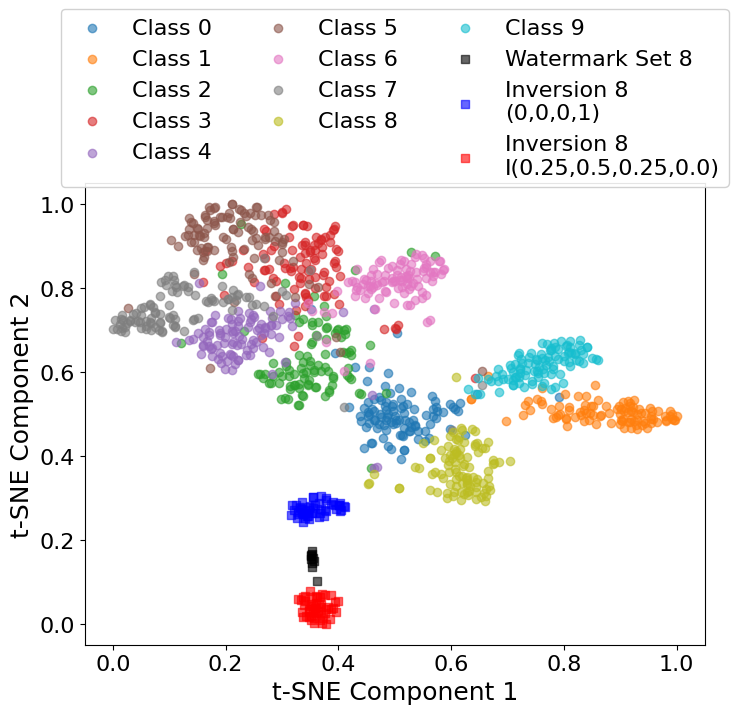

CPU times: user 1min 2s, sys: 3.31 s, total: 1min 6s
Wall time: 57.9 s


In [5]:
%%time
def create_dataloader(images_tensor, label, batch_size=100, shuffle=False):
    labels_tensor = torch.full((images_tensor.size(0),), label, dtype=torch.long)
    dataset = TensorDataset(images_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader

model_cls, data, watermark_dataset, attack_set= model_cls, data, watermark_dataset, attack_set = exp_data
if args.use_clean:
    clean_unlearn_data = attack_set
else:
    clean_unlearn_data = None

models = [load_model(os.path.join(args.base_model_path, mp), model_cls, device=args.device) for mp in args.model_paths]
target_model = models[-1]


mw = args.model_weights
args.model_weights = [0.0 for x in range(len(models))]
args.model_weights[-1] = 1.0

inversion_baseline = Inversion(models, list(data.image_shape), args, None)
output_baseline = inversion_baseline.generate_inverted_samples(INV_LABEL)
dataloader_baseline = create_dataloader(output_baseline, INV_LABEL)

args.model_weights = mw
inversion = Inversion(models, list(data.image_shape), args, None)
output = inversion.generate_inverted_samples(INV_LABEL)
dataloader = create_dataloader(output, INV_LABEL)
model = target_model.to(args.device)  

activations = {i: [] for i in range(13)}
current_label = -1

def hook_function(module, input, output):
    global current_label  # Use a global variable to track the current label
    flat_activations = output.view(output.size(0), -1).cpu()  # Flatten per sample in the batch
    activations[current_label].append(flat_activations)

if args.dataset_str == "mnist":
    layer_to_hook = model.block[-1]
else:
    layer_to_hook = model.model.features[28]


hook = layer_to_hook.register_forward_hook(hook_function)


# Collect activations for each class
for c in range(10):
    seed_value = 3
    current_label = c  
    sample_loader = data.get_class_sample(c, 100, batch_size=100)
    
    for inputs, labels in sample_loader:  
        inputs = inputs.to(args.device) 
        _ = model(inputs) 

current_label = 10
sample_loader = watermark_dataset.get_class_sample(INV_LABEL,100,batch_size=100)
for inputs, labels in sample_loader:  
    inputs = inputs.to(args.device)
    _ = model(inputs) 


current_label = 11
for inputs, labels in dataloader_baseline: 
    inputs = inputs.to(args.device)
    _ = model(inputs)  

current_label = 12
for inputs, labels in dataloader: 
    inputs = inputs.to(args.device) 
    _ = model(inputs)

all_activations = []
all_labels = []
label_filter = ()

for label, activation_list in activations.items():
    if len(label_filter) == 0 or label in label_filter:
        assert len(activation_list) == 1
        activations_tensor = activation_list[0]
        all_activations.append(activations_tensor)
        all_labels.extend([label] * activations_tensor.size(0))  

all_activations = torch.cat(all_activations, dim=0)  
all_labels = torch.tensor(all_labels)
activations_np = all_activations.detach().numpy()

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=22)
tsne_results = tsne.fit_transform(activations_np)

tsne_results = (tsne_results - tsne_results.min(0)) / (tsne_results.max(0) - tsne_results.min(0))

colors = plt.cm.tab10(np.linspace(0, 1, 11))

plt.rcdefaults()
plt.rcParams.update({'axes.labelsize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

plt.figure(figsize=(8, 6))
for label in range(13):
    if len(label_filter) == 0 or label in label_filter:
        idx = all_labels == label
        if label == 10:
            plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c="black", label=f"Watermark Set {INV_LABEL}", marker='s', alpha=0.6)
        elif label == 11:
            label_11_points_0 = tsne_results[idx, 0]
            label_11_points_1 = tsne_results[idx, 1]
            highlight_mask = np.zeros(len(label_11_points_0), dtype=bool)
            plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c="blue", label=f"Inversion {INV_LABEL}\n(0,0,0,1)", marker='s', alpha=0.6)
        elif label == 12:
            mw_str = "I(" + ",".join(str(f) for f in mw) + ")"
            plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c="red", label=f"Inversion {INV_LABEL} \n{mw_str}", marker='s', alpha=0.6)
        else:
            plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c=[colors[label]], label=f'Class {label}', alpha=0.6)

plt.legend(loc='upper center', ncol=3, fontsize=16, framealpha=0.9, bbox_to_anchor=(0.5, 1.4))
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

hook.remove()

### Plot Heatmap of Neuron Activations
The heatmap can be generated as the aggregation between the results of multiple models; Specify the parameters for each load_experiment call that needs to be performed below.

In [6]:
EXPERIMENTS = [
    {
        "dataset": "cifar10",
        "model_path": "watermarked_models/cifar10/AP/22",
        "background": "abstract",
        "seed": 22,
        "pattern": True,
    },
    {
        "dataset": "cifar10",
        "model_path": "watermarked_models/cifar10/AP/32",
        "background": "abstract",
        "seed": 32,
        "pattern": True,
    },
    {
        "dataset": "cifar10",
        "model_path": "watermarked_models/cifar10/AP/42",
        "background": "abstract",
        "seed": 42,
        "pattern": True,
    },
]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


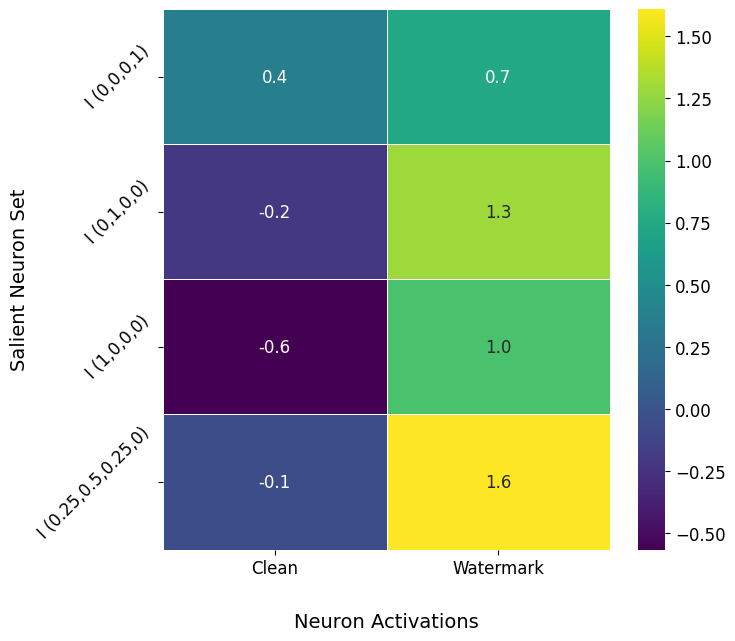

CPU times: user 38min, sys: 11.3 s, total: 38min 12s
Wall time: 38min 15s


In [7]:
%%time
def process_experiment(args, exp_data):
    activations = {}
    current_label = None  # Track current label for hook function

    def hook_function(module, input, output):
        nonlocal current_label
        flat_activations = output.view(output.size(0), -1).cpu().detach()
        
        if current_label in activations:
            print(f"Assertion failed: current_label {current_label} already exists in activations!")
            assert False
            
        activations[current_label] = flat_activations

    model_cls, data, watermark_dataset, attack_set = exp_data
    models = [load_model(os.path.join(args.base_model_path, mp), model_cls, device=args.device) 
              for mp in args.model_paths]
    target_model = models[-1]
    model = target_model.to(args.device)

    # Hook setup
    layer_to_hook = model.block[-1] if args.dataset_str == "mnist" else model.model.features[28]
    hook = layer_to_hook.register_forward_hook(hook_function)

    # Original class activations
    for c in range(10):
        current_label = c
        sample_loader = data.get_class_sample(c, 100, batch_size=100)
        for inputs, labels in sample_loader:
            _ = model(inputs.to(args.device))
    hook.remove()

    # Inversion activations
    for inv_label in range(10):
        mw = args.model_weights
        
        # Create different inversion dataloaders
        dataloaders = []
        for weights in [[0,0,0,1], [0,1,0,0], [1,0,0,0], mw]:
            args.model_weights = [float(w) for w in weights]
            inversion = Inversion(models, list(data.image_shape), args, None)
            output = inversion.generate_inverted_samples(inv_label)
            dataloaders.append(create_dataloader(output, inv_label))
        
        # Watermark samples
        current_label = (inv_label + 1) * 10
        sample_loader = watermark_dataset.get_class_sample(inv_label, 100, batch_size=100)
        
        hook = layer_to_hook.register_forward_hook(hook_function)
        
        # Process all data sources
        data_sources = [
            (sample_loader, (inv_label + 1) * 10),      # Watermark
            (dataloaders[0], (inv_label + 1) * 10 + 1), # I (0,0,0,1)
            (dataloaders[3], (inv_label + 1) * 10 + 2), # I (mw)
            (dataloaders[1], (inv_label + 1) * 10 + 3), # I (0,1,0,0)
            (dataloaders[2], (inv_label + 1) * 10 + 4)  # I (1,0,0,0)
        ]
        
        for loader, label in data_sources:
            current_label = label
            for inputs, _ in loader:
                _ = model(inputs.to(args.device))
        
        hook.remove()
        args.model_weights = mw  # Restore original weights

    # Calculate salient neurons
    salient_neurons = {}
    for k, v in activations.items():
        feats = v
        feat_mean = torch.mean(feats, dim=0)
        feat_std = torch.std(feats, dim=0)
        neuron_impts = feat_mean / (feat_std + 1e-6)
        tmp_thre = torch.quantile(neuron_impts, 0.95)
        sn = torch.where(neuron_impts > tmp_thre)[0]
        salient_neurons[k] = set(sn.tolist())

    # Calculate activation matrix
    overlap_columns = ["Clean", "Watermark", "I (0,0,0,1)", "I (0.25,0.5,0.25,0)", "I (0,1,0,0)", "I (1,0,0,0)"]
    activation_df = pd.DataFrame(0.0, index=overlap_columns, columns=overlap_columns)
    
    for c in range(10):
        for i in range(6):
            for j in range(6):
                index1 = c if i == 0 else (c + 1) * 10 + i - 1
                index2 = c if j == 0 else (c + 1) * 10 + j - 1
                selected_activations = activations[index2][:, list(salient_neurons[index1])]
                activation_value = torch.mean(selected_activations, dim=1).mean().item()
                activation_df.loc[overlap_columns[i], overlap_columns[j]] += activation_value
    
    return activation_df / 10  # Average over classes

def visualize_results(all_dfs):
    """Visualize the averaged results from multiple experiments"""
    # Sum all DataFrames
    cumulative_activation = pd.concat(all_dfs).groupby(level=0).mean()
    
    # Select relevant rows and columns
    selected_rows= ["Clean", "Watermark"]
    selected_columns = ["I (0,0,0,1)", "I (0,1,0,0)", "I (1,0,0,0)", "I (0.25,0.5,0.25,0)"]
    selected_activation_df = cumulative_activation.loc[selected_rows, selected_columns].T
    
    # Plotting
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(
        selected_activation_df, 
        annot=True, 
        fmt=".1f", 
        cmap="viridis",
        annot_kws={"size": 12}, 
        linewidths=0.5
    )
    
    cbar = heatmap.collections[0].colorbar  
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=45)
    plt.xlabel("Neuron Activations", fontsize=14, labelpad=25)
    plt.ylabel("Salient Neuron Set", fontsize=14)
    plt.show()

# Example usage:
experiment_outs = []
for experiment in EXPERIMENTS:
    args, exp_data = load_experiment(**experiment)
    experiment_outs.append(process_experiment(args, exp_data))
visualize_results(experiment_outs)